In [1]:
# importing libraries
import pandas as pd
import numpy as np
from math import log
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

In [2]:
class DecisionStump():
    def __init__(self):
        self.alpha = None        # measures the importance that is assigned to stump
        self.threshold = None    # value to be measured against this threshold value
        self.feature = None      # feature used in stump

In [3]:
class Adaboost():
    #method to train model
    def fit(self, X, y, weak_learner_num):
        m, n = X.shape
        sampleWeight = np.ones(m)         # weight for all samples
        sampleWeight = sampleWeight / m   # initially assigning equal weights to all samples

        self.weak_learners = []         # weak learners
        
        # loop to get weak_learner_num number of weak learners to create a strong learner
        for itr in range(weak_learner_num):
            stump = DecisionStump()     # creating a stump object
            error_threshold = 0.5       # 50% error threshold
            
            # loop to get best feature for decision stump as weak learner
            for feature in range(n):
                values = np.unique(X[:, feature])
                
                # looping over all unique feature value as threshold to get best threshold value
                for threshold in values:
                    label_prediction = np.ones(m,)                      # intially assigning 1 as label for all samples
                    label_prediction[X[:, feature] < threshold] = -1    # setting -1 as label where feature value < threshold
                    
                    error = sum(sampleWeight[y != label_prediction])    # error calculation

                    # updating stump if a better feature with lower error found 
                    if error < error_threshold:
                        stump.threshold = threshold
                        stump.feature = feature
                        error_threshold = error

            stump.alpha = 0.5 * log((1.0 - error_threshold) / (error_threshold + 1e-5)) #updating alpha
            
            #final label prediction with new weak learner
            final_label_prediction = np.ones(m,)                          # intially assigning 1 as label for all samples
            negativeLabels = X[:, stump.feature] < stump.threshold        # getting index of samples belonging to -1 based on threshold
            final_label_prediction[negativeLabels] = -1                   # changing prediction to -1 for negative labels
                       
            sampleWeight = sampleWeight * np.exp(-stump.alpha * y * final_label_prediction)  #updating weights
            sampleWeight = sampleWeight/np.sum(sampleWeight)                                 #normalizing weights
            self.weak_learners.append(stump)                                                 #appending new weak learner
  
    # method to predict labels
    def predict(self, X):
        final_label_prediction = np.zeros(X.shape[0],)                # final label predictions

        # loop to get final label predictions 􏰃
        for wl in self.weak_learners:
            label_prediction = np.ones(X.shape[0],)                    # intially assigning 1 as label for all samples
            negativeLabels = X[:, wl.feature] < wl.threshold           # getting index of samples belonging to -1 based on threshold
            label_prediction[negativeLabels] = -1                      # changing prediction to -1 for negative labels
            final_label_prediction += wl.alpha * label_prediction      # updating final label predictions
    
        # updating labels to -1 and 1 
        final_label_prediction = np.sign(final_label_prediction)
        return final_label_prediction
    
    # method to get model error and accuracy
    def get_error_and_accuracy(self,X, y, y_pred):
        cc_samples = y[y == y_pred].shape[0]         # total correctly_classified_samples  
        accuracy = (cc_samples / y.shape[0]) * 100   # model accuracy

        f_prediction = np.zeros(X.shape[0],)         # final label predictions
        errors = []                                  # errors made in each iteration
        
        # loop to get error made in each iteration
        for wl in self.weak_learners:
            label_prediction = np.ones(X.shape[0],)                   # intially assigning 1 as label for all samples
            negativeLabels = X[:, wl.feature] < wl.threshold          # getting index of samples belonging to -1 based on threshold
            label_prediction[negativeLabels] = -1                     # changing prediction to -1 for negative labels
            f_prediction += wl.alpha * label_prediction               # updating final label predictions
            error = y[y != np.sign(f_prediction)].shape[0]/y.shape[0] # getting error
            errors.append(error)                                      # appending error  
        return cc_samples, accuracy, errors
        



------------------------------------------------------------

Number of weak learners used: 1
Correctly classified training samples:  276 out of 300 .
Correctly classified testing samples:  245 out of 269 .
Training accuracy: 92.0
Testing accuracy: 91.07806691449815


------------------------------------------------------------

Number of weak learners used: 3
Correctly classified training samples:  281 out of 300 .
Correctly classified testing samples:  257 out of 269 .
Training accuracy: 93.66666666666667
Testing accuracy: 95.53903345724906


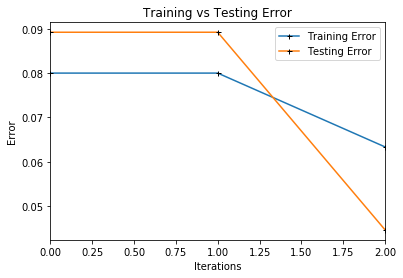



------------------------------------------------------------

Number of weak learners used: 10
Correctly classified training samples:  291 out of 300 .
Correctly classified testing samples:  256 out of 269 .
Training accuracy: 97.0
Testing accuracy: 95.16728624535315


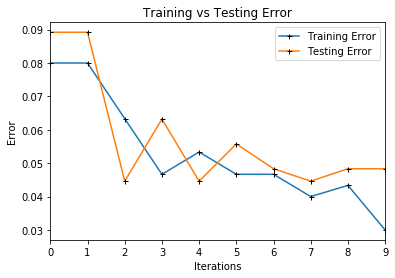



------------------------------------------------------------

Number of weak learners used: 20
Correctly classified training samples:  297 out of 300 .
Correctly classified testing samples:  260 out of 269 .
Training accuracy: 99.0
Testing accuracy: 96.6542750929368


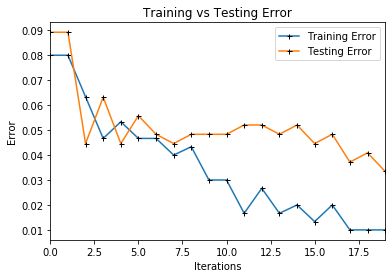



------------------------------------------------------------

Number of weak learners used: 40
Correctly classified training samples:  300 out of 300 .
Correctly classified testing samples:  258 out of 269 .
Training accuracy: 100.0
Testing accuracy: 95.91078066914498


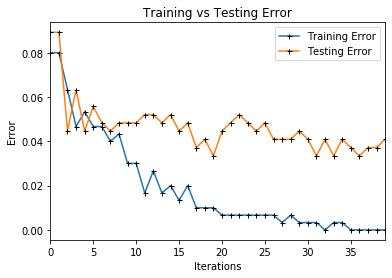



------------------------------------------------------------

Number of weak learners used: 50
Correctly classified training samples:  300 out of 300 .
Correctly classified testing samples:  257 out of 269 .
Training accuracy: 100.0
Testing accuracy: 95.53903345724906


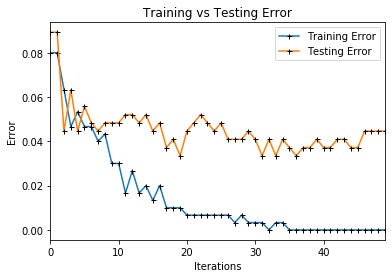

In [4]:
if __name__ == "__main__":
    # reading csv
    data = pd.read_csv("Data/wdbc_data.csv", header=None)
    data.drop([0],axis = 1, inplace = True)              #dropping ID Number
    data.replace({1: {'B': -1, 'M': 1}}, inplace = True) #changing labels B and M to -1 and 1 respectively

    #splitting dataset into training and testing data and training and testing labels
    X_train = np.array(data.iloc[:300, 1: ])
    y_train = np.array(data.iloc[:300, 0])

    X_test = np.array(data.iloc[300:, 1: ])
    y_test = np.array(data.iloc[300:, 0])
    
    weak_learners = [1,3,10,20,40,50]
    for i in weak_learners:
        # training model
        num_of_weak_learners = i
        model = Adaboost()
        model.fit(X_train, y_train,num_of_weak_learners)

        # getting predictions to calculate model accuracy and error
        y_test_predicted = model.predict(X_test)
        y_train_predicted = model.predict(X_train)

        # getting number of correctly classified samples, accuracy and error
        training_cc_samples, training_accuracy, training_error = model.get_error_and_accuracy(X_train, y_train, y_train_predicted)
        testing_cc_samples, testing_accuracy, testing_error = model.get_error_and_accuracy(X_test, y_test, y_test_predicted)

        # weak learners used
        print('\n\n------------------------------------------------------------\n\nNumber of weak learners used:', num_of_weak_learners)

        # correctly classified samples
        print("Correctly classified training samples: ",training_cc_samples,'out of',X_train.shape[0],".\nCorrectly classified testing samples: ",testing_cc_samples,'out of',X_test.shape[0],'.')

        # Accuracy
        print('Training accuracy:',training_accuracy)
        print('Testing accuracy:',testing_accuracy)

        # concatenating error results
        error_result = pd.DataFrame()
        error_result['Training'] = training_error
        error_result['Testing'] = testing_error
        error_result.reset_index(inplace = True)

        # plotting training vs testing error curve
        if(i != 1):
            fig, ax = plt.subplots()
            ax.plot(error_result['index'], error_result['Training'], label='Training Error',marker = "+", markersize = 5, mec = "black")
            ax.plot(error_result['index'], error_result['Testing'], label='Testing Error',marker = "+", markersize = 5,mec = "black")
            plt.xlabel('Iterations')
            plt.ylabel('Error')
            plt.title('Training vs Testing Error')
            plt.xlim((0,num_of_weak_learners-1))
            legend = ax.legend(loc='upper right')
            plt.show()
